## Building an Illness Severity Score Model with xgBoost
## Milan Datathon Demonstration
### C.V. Cosgriff, MIT Critical Data

In this notebook we will go through the steps of building a simple illness severity score model with `xgBoost` using data extracted from the MIMIC-III database. For more about `xgBoost` please see:  _XGBoost: A Scalable Tree Boosting System, arXiv:1603.02754 [cs.LG]_. Our model will use the first ICU stay of the first hospital stay for all patients in the MIMIC-III database age $\geq$ 16 with a length of stay $\gt$ 4h and will be trained on the outcome of __in-hospital mortality__. The model will use information from recorded vital signs, laboratory data, and intervention administration.

We start by setting up our environment and connecting to MIMIC-III via PostgreSQL.

## 0 - Environment

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier, plot_importance

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import psycopg2
dbname = 'mimic'
schema_name = 'mimiciii'
db_schema = 'SET search_path TO {0};'.format(schema_name)
con = psycopg2.connect(database=dbname)

We then extract develop the extraction.

## 1 - Data Extraction

We will extract a small set of variables we hypothesize predict __in-hospital mortality__. These values will be summarized over the first 24 hours in the ICU. In order for the below query to run, you will need the following materialized views generated by the following queries from the MIT Laboratory of Computational Physiology:
* `vitals-first-day.sql`
* `labs-first-day.sql`
* `gcs-first-day.sql`
* `rrt-first-day.sql`
* `ventilation-first-day.sql` (which requires `ventilation-durations.sql`)
* `icustay-detail.sql`
* `elixhauser-ahrq-v37-no-drg-all-icd.sql`

These queries may all be found at the [MIT LCP GitHub repo.](https://github.com/MIT-LCP/mimic-code)

* Vital signs
* Routine laboratory data
* Glasgow coma scale
* Interventions: ventilation, renal replacement therapy
* Comorbidities (from Elixhauser coding)

Our query will also be limited to:
* Age $\geq$ 16 
* Length of stay $\geq$ 4 hours
* The first ICU stay for each hospital admission
* The first hospital admission for each subject

In [2]:
query = db_schema + '''
SELECT ied.subject_id, ied.hadm_id, ied.icustay_id, ied.admission_age
       , ied.gender, ied.ethnicity, ied.los_icu, ied.hospital_expire_flag
       , vt.heartrate_min, vt.heartrate_max, vt.heartrate_mean
       , vt.meanbp_min AS map_min, vt.meanbp_max AS map_max
       , vt.meanbp_mean AS map_mean, vt.resprate_min, vt.resprate_max
       , vt.resprate_mean, vt.spo2_min, vt.spo2_max, vt.tempc_min
       , vt.tempc_max, lb.creatinine_max AS scr_max, lb.bun_max AS bun
       , lb.sodium_max AS sodium, lb.potassium_max AS potassium
       , lb.hemoglobin_min AS hemoglobin, lb.wbc_max AS wbc
       , lb.lactate_max AS lactate, uof.urineoutput, vfd.vent, rfd.rrt
       , gcs.mingcs AS gcs_min, gcs.gcsmotor, gcs.gcsverbal, gcs.gcseyes
       , elix.congestive_heart_failure, elix.cardiac_arrhythmias
       , elix.valvular_disease, elix.pulmonary_circulation
       , elix.peripheral_vascular, elix.hypertension
       , elix.paralysis, elix.other_neurological
       , elix.chronic_pulmonary, elix.diabetes_uncomplicated
       , elix.diabetes_complicated, elix.hypothyroidism
       , elix.renal_failure, elix.liver_disease
       , elix.peptic_ulcer, elix.aids
       , elix.lymphoma, elix.metastatic_cancer
       , elix.solid_tumor, elix.rheumatoid_arthritis
       , elix.coagulopathy, elix.obesity
       , elix.weight_loss, elix.fluid_electrolyte
       , elix.blood_loss_anemia, elix.deficiency_anemias
       , elix.alcohol_abuse, elix.drug_abuse, elix.psychoses
       , elix.depression
FROM icustay_detail ied
INNER JOIN vitalsfirstday vt -- require vital signals
    ON ied.icustay_id = vt.icustay_id
INNER JOIN labsfirstday lb -- require lab signals
    ON ied.icustay_id = lb.icustay_id
LEFT OUTER JOIN uofirstday uof -- pull in uo data, null if absent
    ON ied.icustay_id = uof.icustay_id
LEFT OUTER join ventfirstday vfd -- ventfirstday flag
    ON ied.icustay_id = vfd.icustay_id
LEFT OUTER JOIN rrtfirstday rfd -- rrt flag
    ON ied.icustay_id = rfd.icustay_id
LEFT OUTER JOIN gcsfirstday gcs
    ON ied.icustay_id = gcs.icustay_id
LEFT OUTER JOIN elixhauser_ahrq_no_drg_all_icd elix
    ON ied.hadm_id = elix.hadm_id
WHERE first_icu_stay = TRUE
AND first_hosp_stay = TRUE
AND ied.admission_age >= 16.0 -- limite age to 16
AND ied.los_icu >= 0.167;
'''

df = pd.read_sql_query(query, con)
display(df.head())
print(df.shape)

,subject_id,hadm_id,icustay_id,admission_age,gender,ethnicity,los_icu,hospital_expire_flag,heartrate_min,heartrate_max,...,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
0,6,107064,228232,65.9407,F,WHITE,3.6729,0,76.0,100.0,...,0,0,0,1,0,1,0,0,0,0
1,22,165315,204798,64.9282,F,WHITE,1.1438,0,85.0,122.0,...,0,0,0,0,0,0,0,0,1,0
2,37,188670,213503,68.9288,M,WHITE,1.1397,0,69.0,91.0,...,0,0,0,0,0,0,0,0,0,0
3,238,174168,208413,57.3957,M,WHITE,2.0961,0,68.0,93.0,...,0,0,0,0,0,0,0,0,0,0
4,246,197430,287265,68.7635,M,WHITE,1.1789,0,79.0,115.0,...,0,1,0,0,0,0,0,0,0,0


(38295, 65)


Following the extraction, we'll look at our a tabular summary of our data to get an initial idea about the data we extracted. For this demonstration we won't go to crazy with data cleaning, but in a real scenario this would be the start of the most important part of the model development process.

In [3]:
with (pd.option_context("display.max_rows", None)):
    display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
subject_id,38295.0,38353.029952,29388.567084,3.000000,14036.500000,27993.000000,63073.500000,99999.000000
hadm_id,38295.0,150035.196031,28946.925224,100001.000000,124926.500000,150077.000000,175221.500000,199999.000000
icustay_id,38295.0,250228.119258,28922.204448,200003.000000,225232.500000,250300.000000,275301.500000,299999.000000
admission_age,38295.0,74.551941,55.081929,16.016300,52.324250,65.672000,77.902300,310.280900
los_icu,38295.0,4.071289,6.010574,0.168400,1.194500,2.101400,4.100050,153.928000
hospital_expire_flag,38295.0,0.113853,0.317637,0.000000,0.000000,0.000000,0.000000,1.000000
heartrate_min,38193.0,70.639184,15.081280,0.350000,60.000000,70.000000,80.000000,140.000000
heartrate_max,38193.0,103.285620,20.608646,30.000000,89.000000,101.000000,116.000000,280.000000
heartrate_mean,38193.0,85.150733,15.598367,30.000000,74.269231,84.086957,94.937500,154.972222
map_min,38190.0,58.810488,13.577549,0.200000,52.000000,59.000000,66.666702,125.000000


Some observations from this table:
* The max age is ~310 __this is because of HIPPA, we'll need to fix the ages__; for this we can use 91.4, the median age for these excluded patients (per the LCP)
* The mean length of stay in the ICU is ~4 days and the median is ~2 days
* The mortality is approximately 11%
* Urine output has a max of 561190 on the first day, which seems unreasonable, and appears to be a data error; urine output also shouldn't be negative.
* ~46% of patients were ventilated on day 1 and ~2% recieved RRT

We'll fix age and urine output; there is lots more we could fix here, but for the sake of this presentation thats enough.

In [4]:
df.loc[df.admission_age > 100, 'admission_age'] = 91.4 # fix age
df = df.loc[df.urineoutput <= 15000, :] # exclude patients with absurd urine output
df = df.loc[df.urineoutput >= 0, :] # exclude patients with negative urine output

Lets also flip over character variables to numerical.

These include gender and ethnicity. For ethnicity we first need to check the levels.

In [5]:
pd.Categorical(df.ethnicity).categories

Index(['AMERICAN INDIAN/ALASKA NATIVE',
       'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'ASIAN',
       'ASIAN - ASIAN INDIAN', 'ASIAN - CAMBODIAN', 'ASIAN - CHINESE',
       'ASIAN - FILIPINO', 'ASIAN - JAPANESE', 'ASIAN - KOREAN',
       'ASIAN - OTHER', 'ASIAN - THAI', 'ASIAN - VIETNAMESE', 'BLACK/AFRICAN',
       'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'CARIBBEAN ISLAND', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - CUBAN',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - SALVADORAN',
       'MIDDLE EASTERN', 'MULTI RACE ETHNICITY',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'OTHER',
       'PATIENT DECLINED TO ANSWER', 'PORTUGUESE', 'SOUTH AMERICAN',
       'UNABLE TO OBTAIN', 'UNKNOWN/NOT SP

We certainly don't want to create dummy variables for all of these different categories. Instead we'll map them all to the following general buckets using a dictionary:
* White
* Black
* Hispanic
* Asian
* Other

In [6]:
eth_map = {'AMERICAN INDIAN/ALASKA NATIVE' : 'other',
           'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE' : 'other',
           'ASIAN' : 'asian','ASIAN - ASIAN INDIAN' : 'asian',
           'ASIAN - CAMBODIAN' : 'asian', 'ASIAN - CHINESE' : 'asian',
           'ASIAN - FILIPINO' : 'asian', 'ASIAN - JAPANESE' : 'asian', 
           'ASIAN - KOREAN' : 'asian', 'ASIAN - OTHER' : 'asian', 'ASIAN - THAI' : 'asian', 
           'ASIAN - VIETNAMESE' : 'asian', 'BLACK/AFRICAN' : 'black',
           'BLACK/AFRICAN AMERICAN' : 'black', 'BLACK/CAPE VERDEAN' : 'black', 
           'BLACK/HAITIAN' : 'black', 'CARIBBEAN ISLAND' : 'black', 
           'HISPANIC OR LATINO' : 'hispanic',
           'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)' : 'hispanic',
           'HISPANIC/LATINO - COLOMBIAN' : 'hispanic', 
           'HISPANIC/LATINO - CUBAN' : 'hispanic',
           'HISPANIC/LATINO - DOMINICAN' : 'hispanic', 
           'HISPANIC/LATINO - GUATEMALAN' : 'hispanic',
           'HISPANIC/LATINO - HONDURAN' : 'hispanic', 
           'HISPANIC/LATINO - MEXICAN' : 'hispanic',
           'HISPANIC/LATINO - PUERTO RICAN' : 'hispanic', 
           'HISPANIC/LATINO - SALVADORAN' : 'hispanic',
           'MIDDLE EASTERN' : 'other', 'MULTI RACE ETHNICITY' : 'other',
           'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' : 'other', 
           'OTHER' : 'other',
           'PATIENT DECLINED TO ANSWER' : 'other', 
           'PORTUGUESE' : 'white', 
           'SOUTH AMERICAN' : 'hispanic',
           'UNABLE TO OBTAIN' : 'other', 
           'UNKNOWN/NOT SPECIFIED' : 'other', 'WHITE': 'white',
           'WHITE - BRAZILIAN' : 'white', 'WHITE - EASTERN EUROPEAN' : 'white',
           'WHITE - OTHER EUROPEAN' : 'white', 'WHITE - RUSSIAN' : 'white'}
df = df.assign(ethnicity=df.ethnicity.map(eth_map))

With ethnicity mapped we then want to convert this character variable to numerical dummy variables, dropping one of them as $p-1$ is sufficient to fully specifiy each subject.

In [7]:
df = pd.concat([df.drop('ethnicity', axis=1), pd.get_dummies(df.ethnicity, prefix='eth', drop_first=True)], axis=1)

We give the gender variable a similar treatment, arbitrarily generating a binary variable for `male_gender`.

In [8]:
male_gender = (df.gender == 'M').astype(int)
df = df.assign(male_gender=male_gender).drop('gender', axis=1)

At this point we'll create a held out testing set. Although we will only briefly peruse the data in this notebook's exploratory analysis, it is best practice to split off your data before even this stage so as to not introduce any leakge of bias from testing to training set during the model development process. The following code creates a random test set with 25% of the data. You may note we drop the `hadm_id` and `subject_id` as they are not necessary here because by only including the first hospital stay and the first ICU stay, the `icustay_id` is all that is needed to specify each patient.

In [9]:
df = df.drop(['subject_id', 'hadm_id'], axis=1).set_index('icustay_id')
train_df, test_df = train_test_split(df, test_size=0.25)

## 2 - Exploratory Analysis

Before building models a good exploratory analysis is crucial to attaining a better understanding of the data we are working with; herein we will generate some charts that should allow us to understand the data and check our intuition. For the purpose of this demonstration we will produce a couple of random charts to highlight how it is done, but we will not produce an exhaustive exploration as would be requisite in a real predictive modeling project.

We start by visualizing missingness in our data.

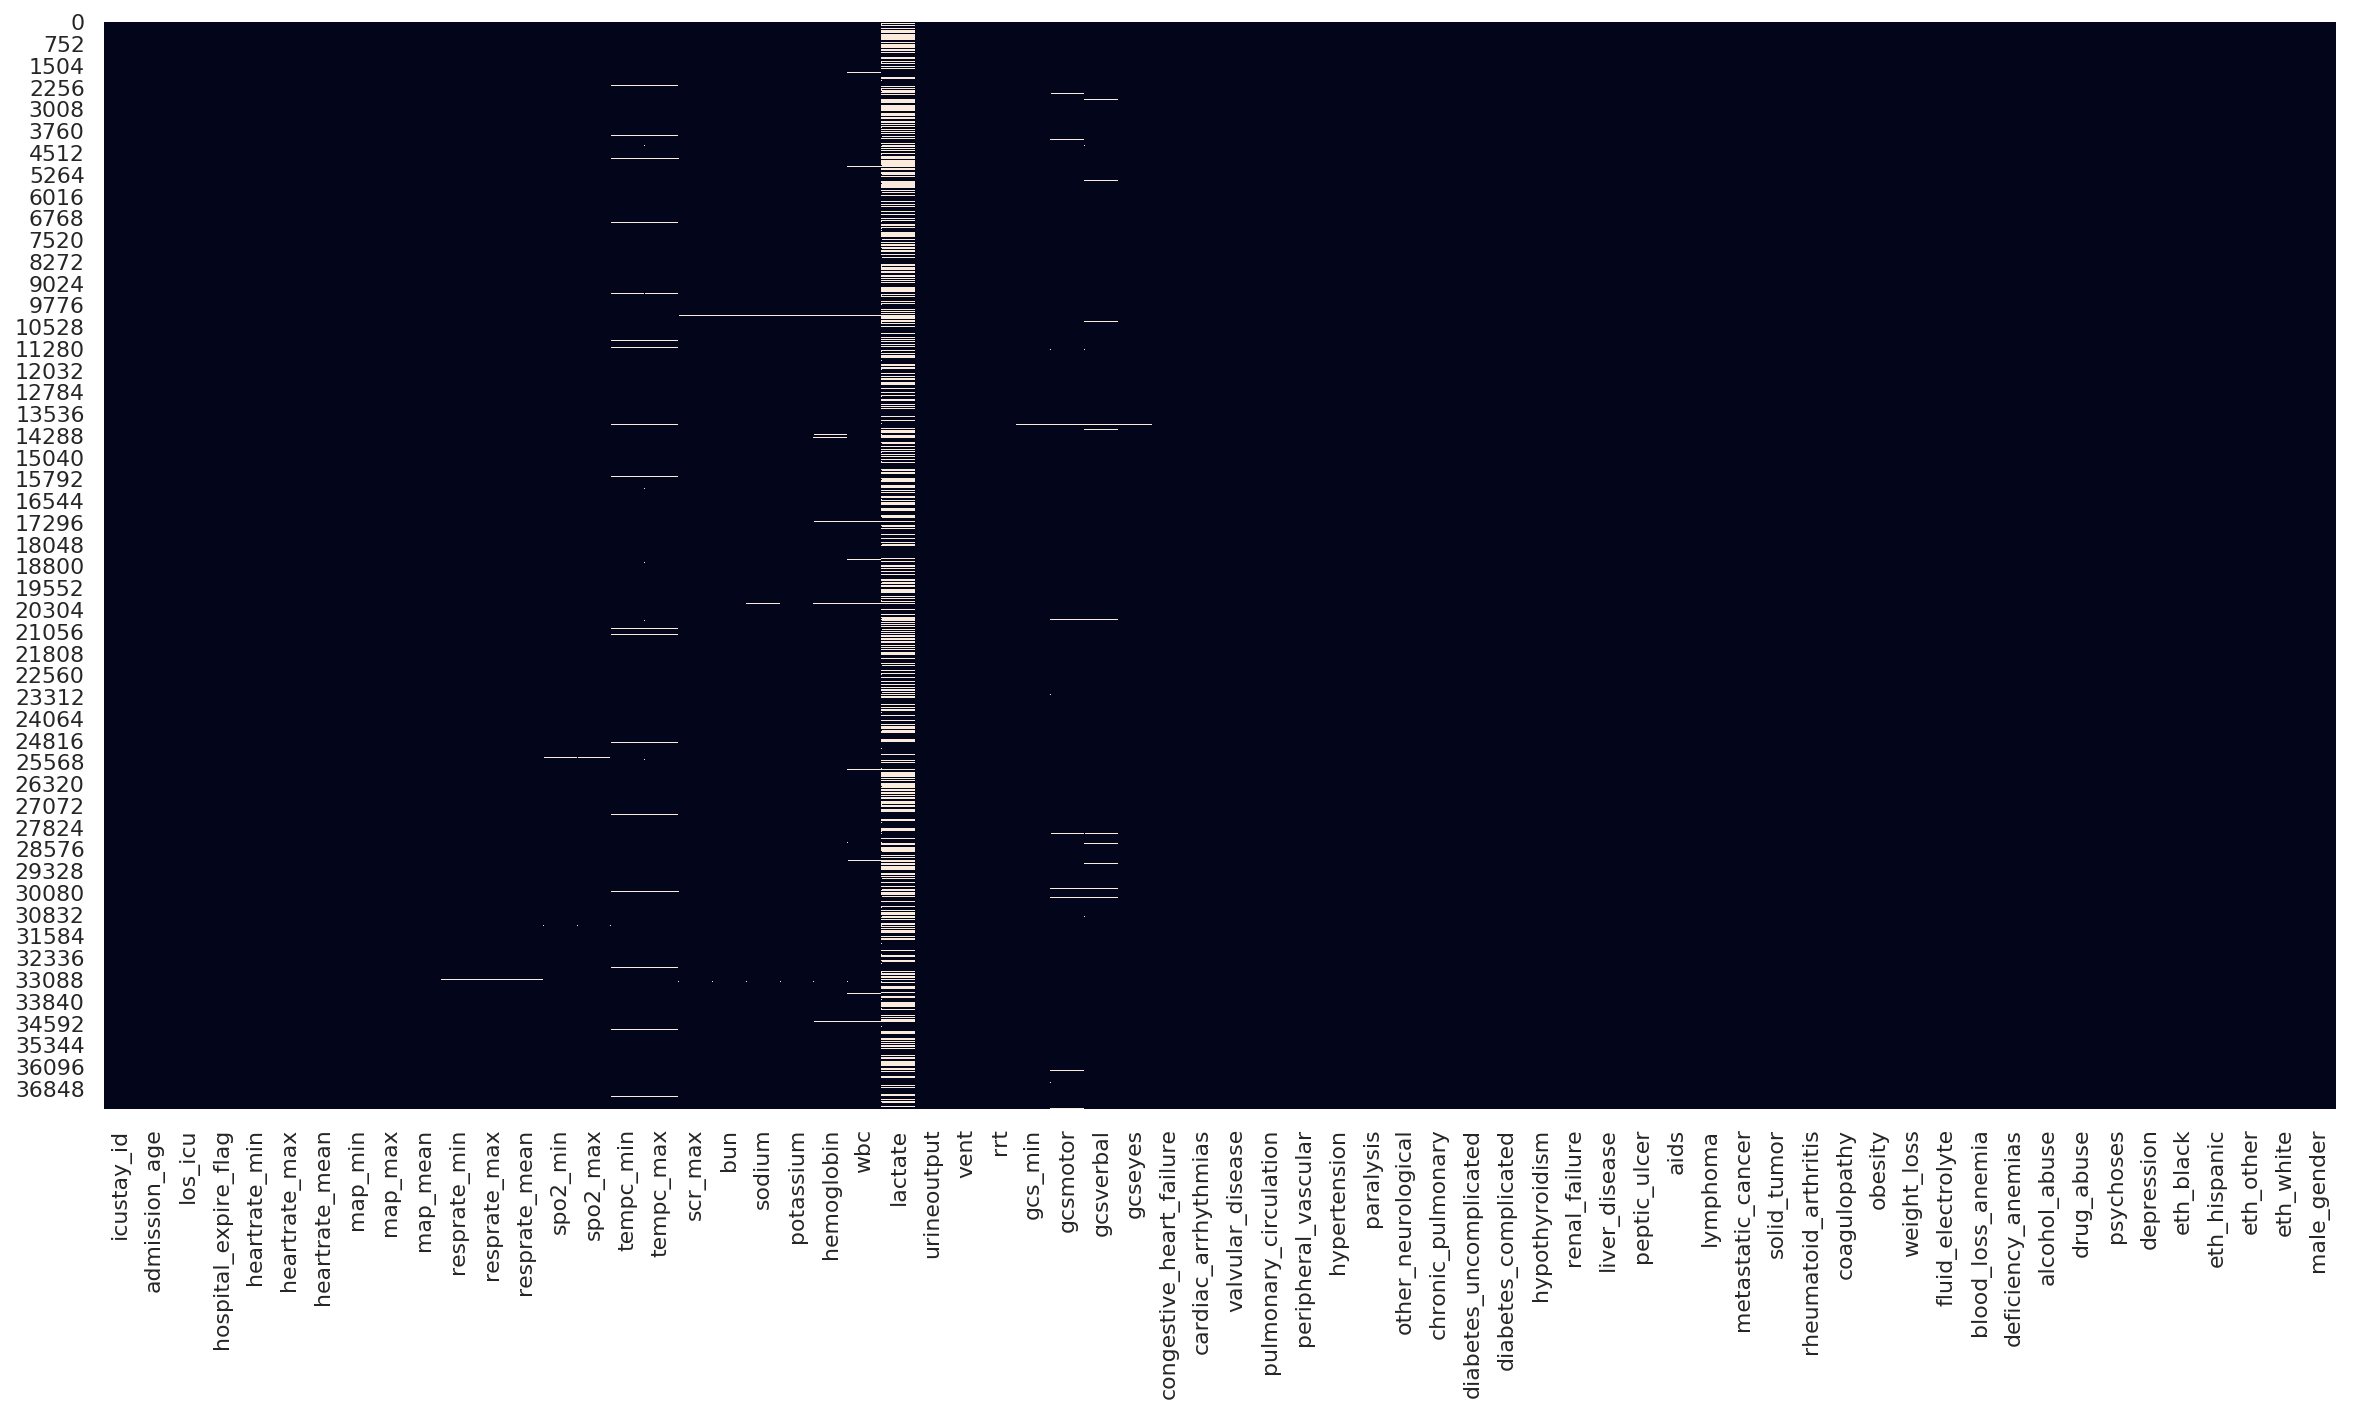

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(df.reset_index().isna(), cbar=False)

We note that most patients have most of the data recorded; a noteable exception is lactate. Lactate is virtually __never__ missing at random. Instead, we can infer that these were patients in whom the clinicians feared end organs were not being perfused. It is important to realize that in data taken from an ICU EHR, variables are almost never missing at random. For predictive modeling, this may have an effect on the generalizability of our models. If we were pursuing causal inference, this would pose an even greater threat to validity. Because we will build our model with _xgBoost_ we will not employ an imputation approach here. (for more on this see: https://github.com/dmlc/xgboost/issues/21)

We can next look at the distribution and correlation of the some of the vital parameters we extracted.

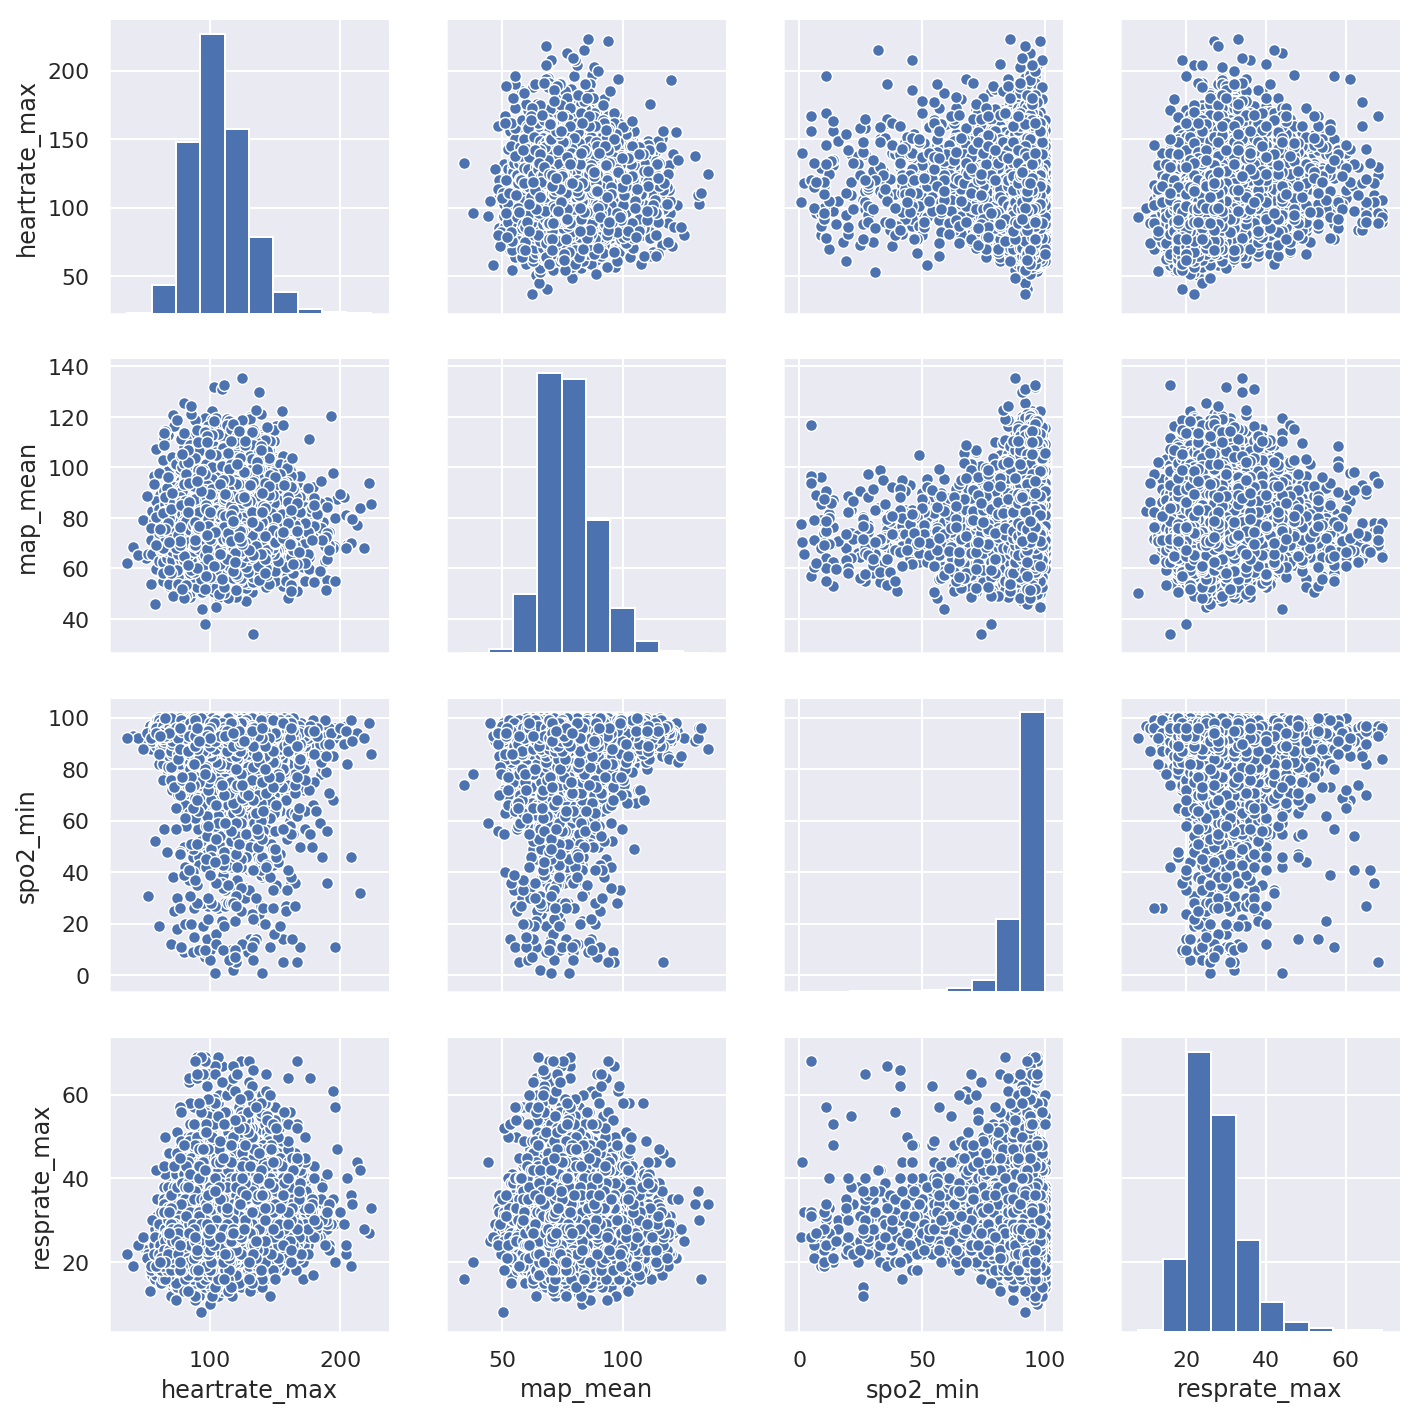

In [11]:
sns.pairplot(train_df.dropna(), vars=['heartrate_max', 'map_mean', 'spo2_min', 'resprate_max'])

Heart rate, MAP, and respiratory rate appear approximately normally distributed; SpO2, as expected, is skewed. If we were using a linear model we might consider transforming SpO2, but it is not neccessary for this approach. 

We can examine the same data, but stratify by outcome.

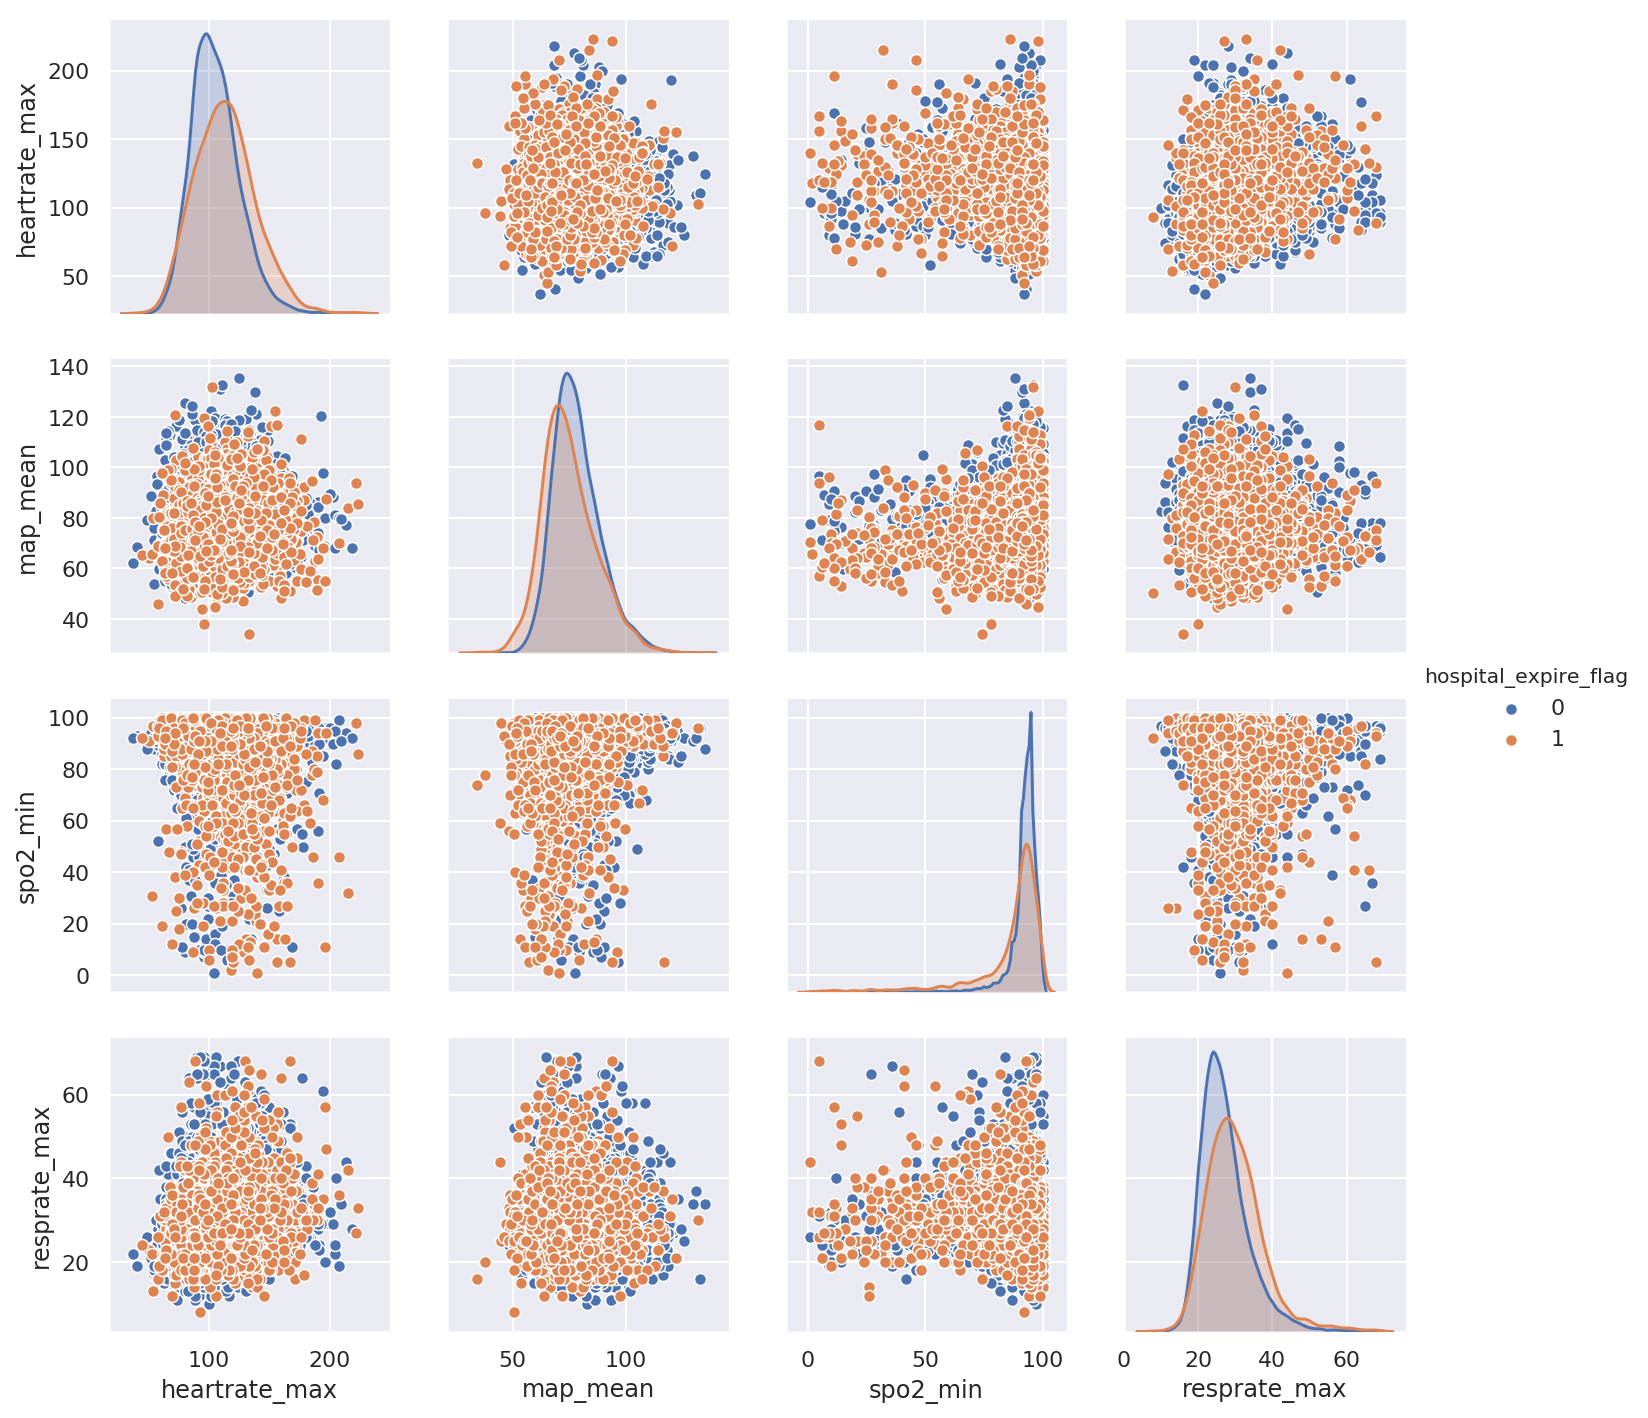

In [12]:
sns.pairplot(train_df.dropna(), vars=['heartrate_max', 'map_mean', 'spo2_min', 'resprate_max'], hue='hospital_expire_flag')

We note slight shifts in the distributions, in the directions we would expect. Our data contains binary indicator variables for two treatments that could be offered on the first day: RRT and invasive ventilation. These are offered to our sickest patients, and in general, patients recieving them will have a higher mortality than groups not recieving them under non-random conditions. We can check this by examining the mortality in each strata and see if it agrees with our intuition.

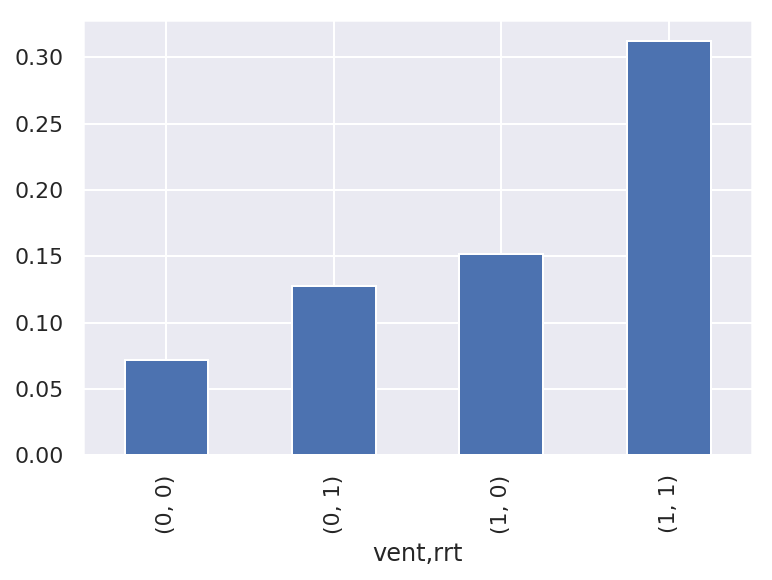

In [13]:
train_df.groupby(by=['vent', 'rrt']).hospital_expire_flag.mean().plot(kind='bar')

And we note that it does! Part of our extraction included comorbidity flags. Lets built point plots with some of them to see how common comorbidities affect mortality risk and thus why including these data is useful. We'll look at congestive heart failure and metastatic cancer, both of which should strongly predict the outcome.

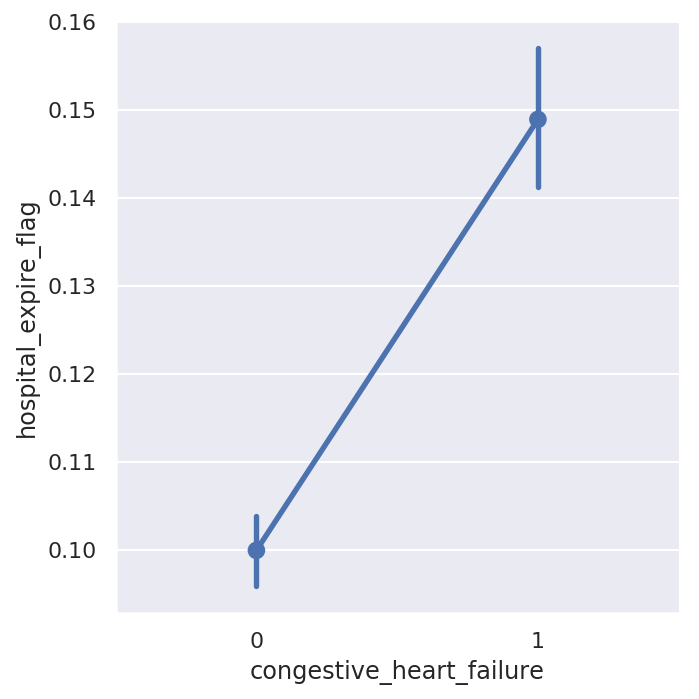

In [14]:
sns.catplot(x='congestive_heart_failure', y='hospital_expire_flag', kind='point', data=train_df, )

Perhaps we are curious how gender affects mortality in CHF. We could make a similar bar chart as we did with ventilation and RRT or we could add it as a categorical variable via `hue` to the point plot. Lets try this latter option.

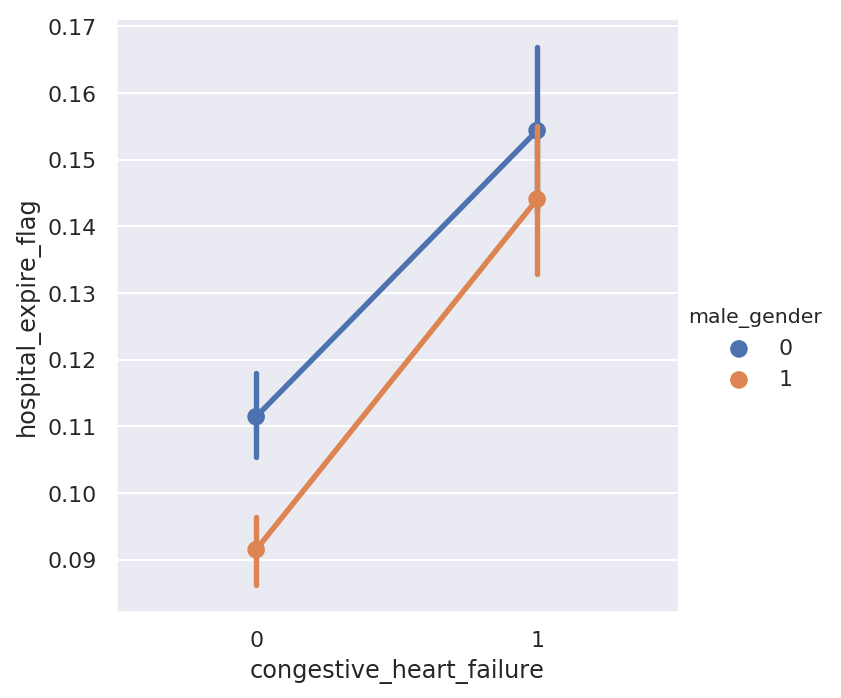

In [15]:
sns.catplot(x='congestive_heart_failure', y='hospital_expire_flag', kind='point', data=train_df, hue='male_gender')

It would appear that women with and without CHF die more than men with and without CHF, respectively. Lets produce the same plots for patients admitted for metastatic cancer.

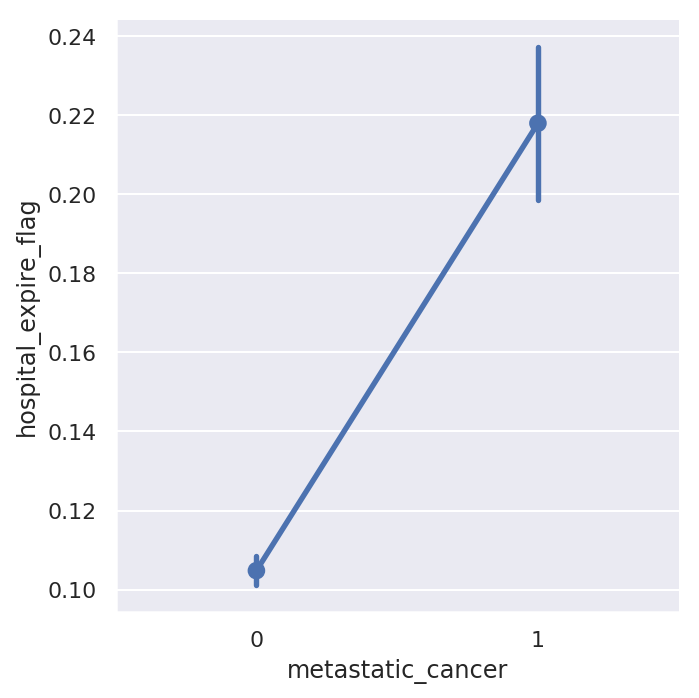

In [16]:
sns.catplot(x='metastatic_cancer', y='hospital_expire_flag', kind='point', data=train_df)

As we would expect, those diagnosed with metastatic cancer are at a much higher risk of death.

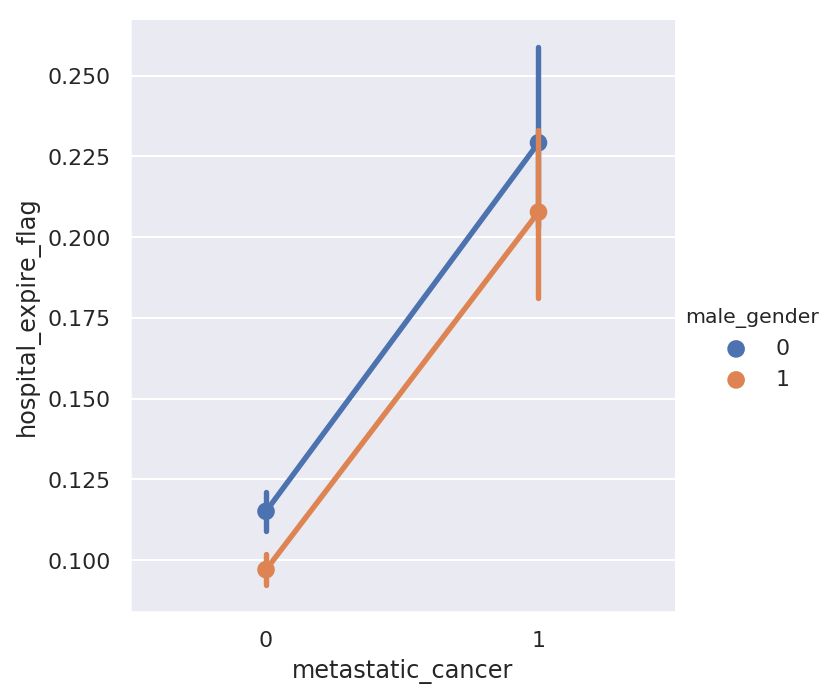

In [17]:
sns.catplot(x='metastatic_cancer', y='hospital_expire_flag', kind='point', data=train_df, hue='male_gender')

And we note a neglibible association with gender. Lets examine ethnicity of white vs. non-white.

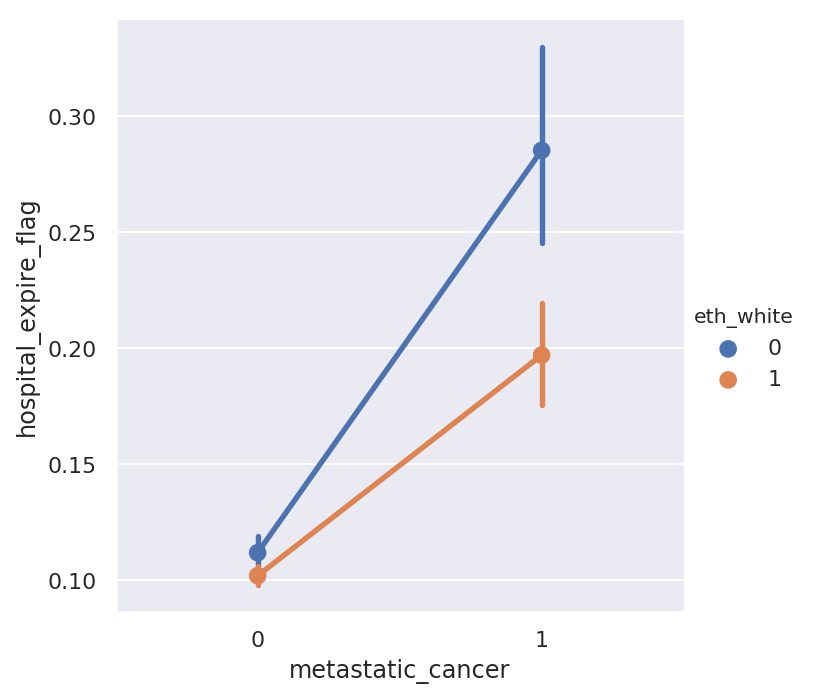

In [18]:
sns.catplot(x='metastatic_cancer', y='hospital_expire_flag', kind='point', data=train_df, hue='eth_white')

A well known structural issue, we note here that in patients with metastatic cancer, white patients have ~20% mortality as compared ~30% in non-white patients. This introduces a complicated point: ethnicity certainly predicts mortality, and it is essentially capturing a very complicated pathway inherent to societal inequity that may not generalize to other hospital populations outside of Boston or the United States. Perhaps if we adjusted for socioeconomic status or distance from the hospital this affect would disappear and race is merely opening a back door pathway, but we do not have these variables in our data. These nuances are what seperate predictive and causal models, and are a reminder of the dangers inherent in using models designed to predict in the absence of an understanding of causality.

Finally, our data contain elements of the Glasgow coma scale which is almost certainly an important predictor. There are lots of ways we could look at these data and see if they differ between those who die in the hospital and those who don't. One popular way to visualize this is via a violin plot. Lets look at the GCS motor component this way.

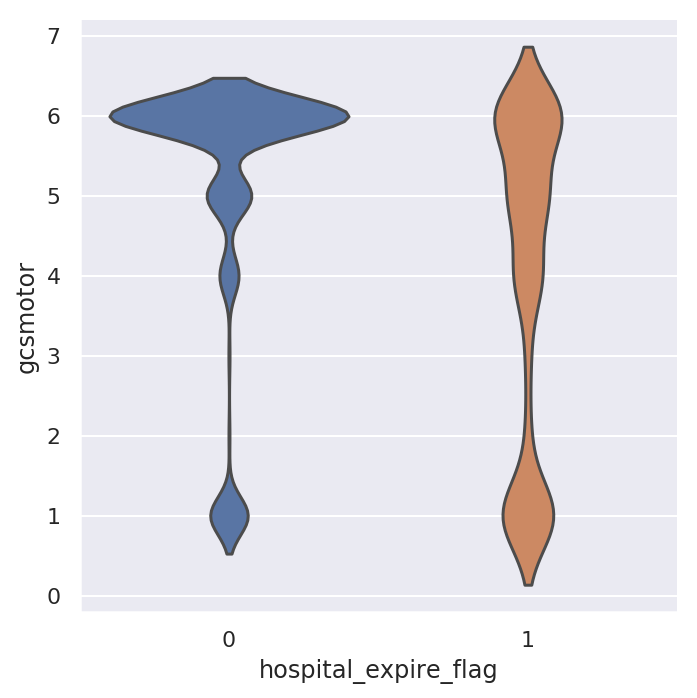

In [19]:
sns.catplot(data=train_df.dropna(), x='hospital_expire_flag', y='gcsmotor', kind='violin', inner=None)

As we might expect, those who survive appear much more likely to have a high GCS, whereas those who die have motor scores across the spectrum. Severe injury resulting in motor impairment would likely be associated with death, and again we have verified some of our intuitions.

One last interesting plot is to look at parameters associated with end stage renal disease and stratify based on whether or not the patient was recieving renal replacement therapy on entry to the ICU.

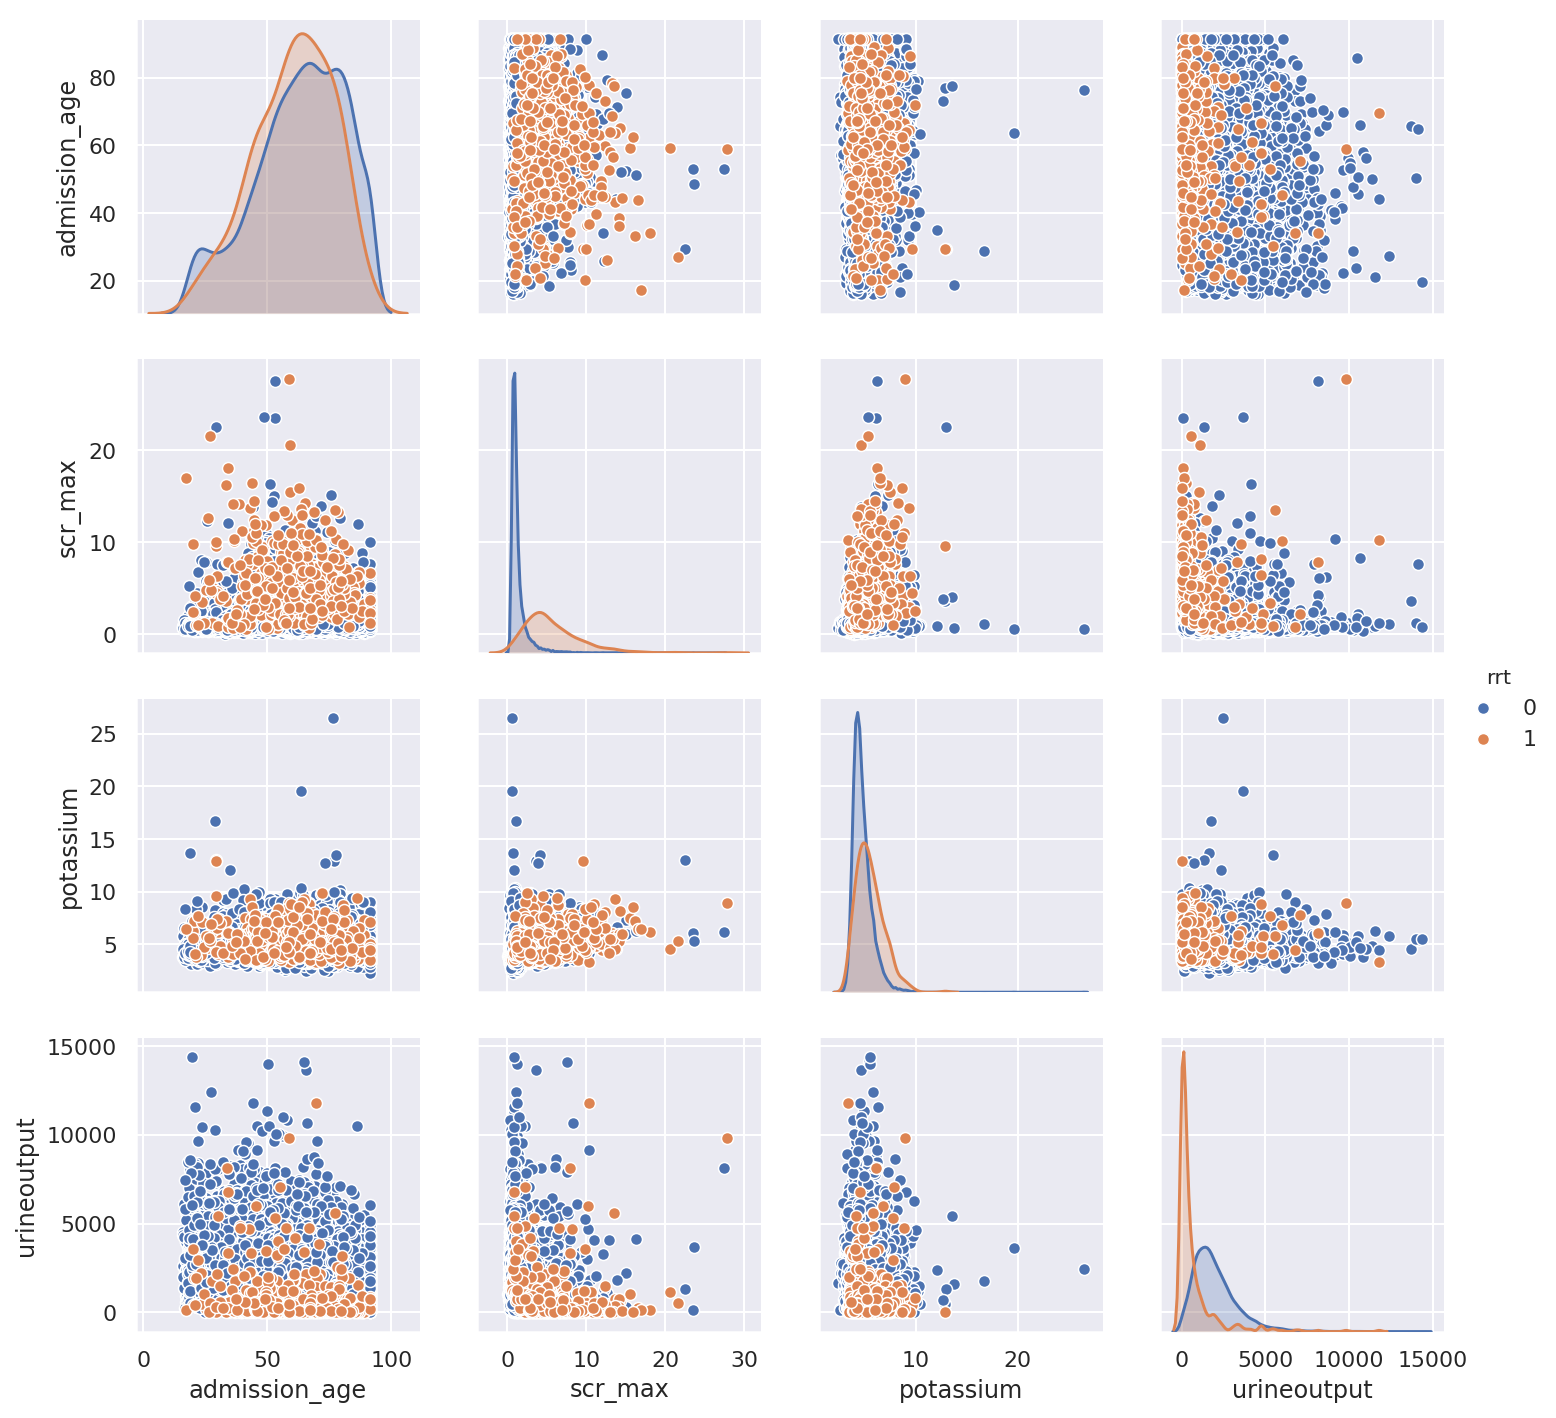

In [20]:
sns.pairplot(train_df.dropna(), vars=['admission_age', 'scr_max', 'potassium', 'urineoutput'], hue='rrt')

This appear in line with our expectations. RRT patients have a wider, right shifted sCr and potassium distribution, and patients with RRT have minimal urine output as compared to patients off RRT. 

Although we could generate many more ways of looking at the data and asking questions, we will turn to modeling so that we can go through the procedure of building a gradient boosting classifier in the remainder of this notebook. The reader is encouraged to always carry out a detailed exploration of the dataset in which they are building models.

## 3 - Model Development

We start by generating splitting off the predictors from the label, storing them in $X$ and $y$ labeled training dataframes. Its important to not train your model using data that includes the label or you'll fool yourself into a perfect classifier.

In [21]:
train_X = train_df.drop(['hospital_expire_flag', 'los_icu'], axis=1)
train_y = train_df.loc[:, 'hospital_expire_flag']

Next, we build a baseline classifier for comparison with our _fancy_ xgBoost model. We'll use logistic regression for this baseline. Of note, regression does not have a built in way to handle missingness and so we'll construct the following modeling pipeline:

1) Impute the median for all missing parameters
2) Center and scale the data (this is useful in regression, but not necessary with tree based models)
3) Finally, train a logistic regression model; we set the _C_ to a very high number so as to disable regularization. Read the `scikit-learn` documentation for more on this.

In [22]:
logistic_classifier = Pipeline([('impute', SimpleImputer(strategy='median')),
                                ('center_scale', StandardScaler()),
                                ('logit', LogisticRegression(C=10**9, solver='lbfgs'))])
logistic_classifier.fit(train_X, train_y)

Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('center_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

Finally, we train the gradient boosting classifier. Hyperparameters will be obtained by a random sampling of the hyperparaemter space, as opposed to an exhaustive grid search. Bergstra et al. showed this to be superior whilst remaining computationally cheaper _(Journal of Machine Learning Research 13 (2012) 281-30)_. 

Our version of `xgBoost` is compiled to use a GPU, and thus we'll use the GPU version of the fast histogram algorithim; the GPU on this machine is a Titan Xp. For users who have not custom compiled xgBoost, you will need to remove these options from the `XGBClassifier` declaration. For more information on this please see the `xgBoost` documentation.

We'll use 5-fold cross validation, and sample from the grid 100 times. I've added comments to every line here so that the reader can tweak and reproduce this in their own projects. The reader should be aware that `xgBoost` has its own methods for carrying out parameter selection, but it is my preference to use `scikit-learn` with `xgBoost` as I have below as it allows you to develop pipelines with multiple different models and promotes a uniform way of modeling in Python.

In [23]:
# we specify the parameter space using commonly selected options
params = {'objective':['binary:logistic'],
          'learning_rate': [0.01, 0.05, 0.10],
          'max_depth': [3, 6, 9, 12],
          'min_child_weight': [6, 8, 10, 12],
          'silent': [True],
          'subsample': [0.6, 0.8, 1],
          'colsample_bytree': [0.5, 0.75, 1],
          'n_estimators': [500, 750, 1000]}

# K represents the number of CV folds; we use 5, but it can
# be lowered or increased depending on how much computer
# power you have available.
K = 5

# next, we construct the classifer; remove the tree_method and
# predictor options if you do not have a GPU version of xgBoost
# compiled in your environment
xgb_model = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')

# then set up your cross validation folds
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# and specify how options for random grid search, passing in your model,
# parameters, the scoring (here I use negative log loss), the number
# of jobs to use (set to your CPU number), and the stratified CV fold
# we declared just above. Lastly, set the random state for reproducibility.
cv_grid_search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                                    n_iter=100, scoring='neg_log_loss', n_jobs=4, 
                                    cv=skf.split(train_X, train_y), 
                                    verbose=2, random_state=42)

# finally, fit the model
cv_grid_search.fit(train_X, train_y)

# output the result of the grid search
print('Optimal negative log-loss estimated by 5-fold CV: {0:.3f}'.format(cv_grid_search.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 27.7min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 39.5min finished


Optimal negative log-loss estimated by 5-fold CV: -0.212


With the hyperparameter search complete, we use the best set of hyperparameters to train a final model on all of the data.

In [24]:
xgb_classifier = cv_grid_search.best_estimator_
xgb_classifier.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=9, min_child_weight=6, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6, tree_method='gpu_hist')

## 4 - Model Analysis

With our model training complete, we turn to examining our model on the held-out test set. We will review the reciever-operator characteristic curve for discrimination, the reliability curve for calibration, and the precision-recall curve for a different take on the value of these models considering the ~11% event rate.

We start by writing some simple functions to generate the plots we desire.

In [25]:
def gen_auc_plot(models, names, title, X, y, save_name=None):
    plt.figure(figsize=(10, 10))
    for i, model in enumerate(models):
        f_hat = model.predict_proba(X)
        roc = roc_curve(y, f_hat[:, 1])
        auc = roc_auc_score(y, f_hat[:, 1])
        sns.lineplot(x=roc[0], y=roc[1], label='{0}\n(AUC = {1:.3f})'.format(names[i], auc))
    plt.plot([0, 1], [0, 1], 'k:')
    plt.xlabel('1 - Specificty')
    plt.ylabel('Sensitivity')
    plt.title(title)
    
def gen_calib_plot(models, names, title, X, y, save_name=None):
    plt.figure(figsize=(10, 10))
    for i, model in enumerate(models):
        f_hat = model.predict_proba(X)
        fraction_of_positives, mean_predicted_value = calibration_curve(y, f_hat[:, 1], n_bins=8)
        sns.lineplot(x=mean_predicted_value, y=fraction_of_positives, label=names[i])
    plt.plot([0, 1], [0, 1], 'k:')
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Actual Probability of Outcome')
    plt.title(title)
    
def gen_prc_plot(models, names, title, X, y, save_name=None):
    plt.figure(figsize=(10, 10))
    for i, model in enumerate(models):
        f_hat = model.predict_proba(X)
        precision, recall, _ = precision_recall_curve(y, f_hat[:, 1])
        ap = average_precision_score(y, f_hat[:, 1])
        sns.lineplot(x=recall, y=precision, label='{0}\n(AP = {1:.3f})'.format(names[i], ap))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)

Then, as we did above, splif the testing data into $X$ and $y$.

In [26]:
test_X = test_df.drop(['hospital_expire_flag', 'los_icu'], axis=1)
test_y = test_df.loc[:, 'hospital_expire_flag']

We then pass our models and test data to the functions we wrote. We'll start with the reciever-operator characteristic (ROC) curves.

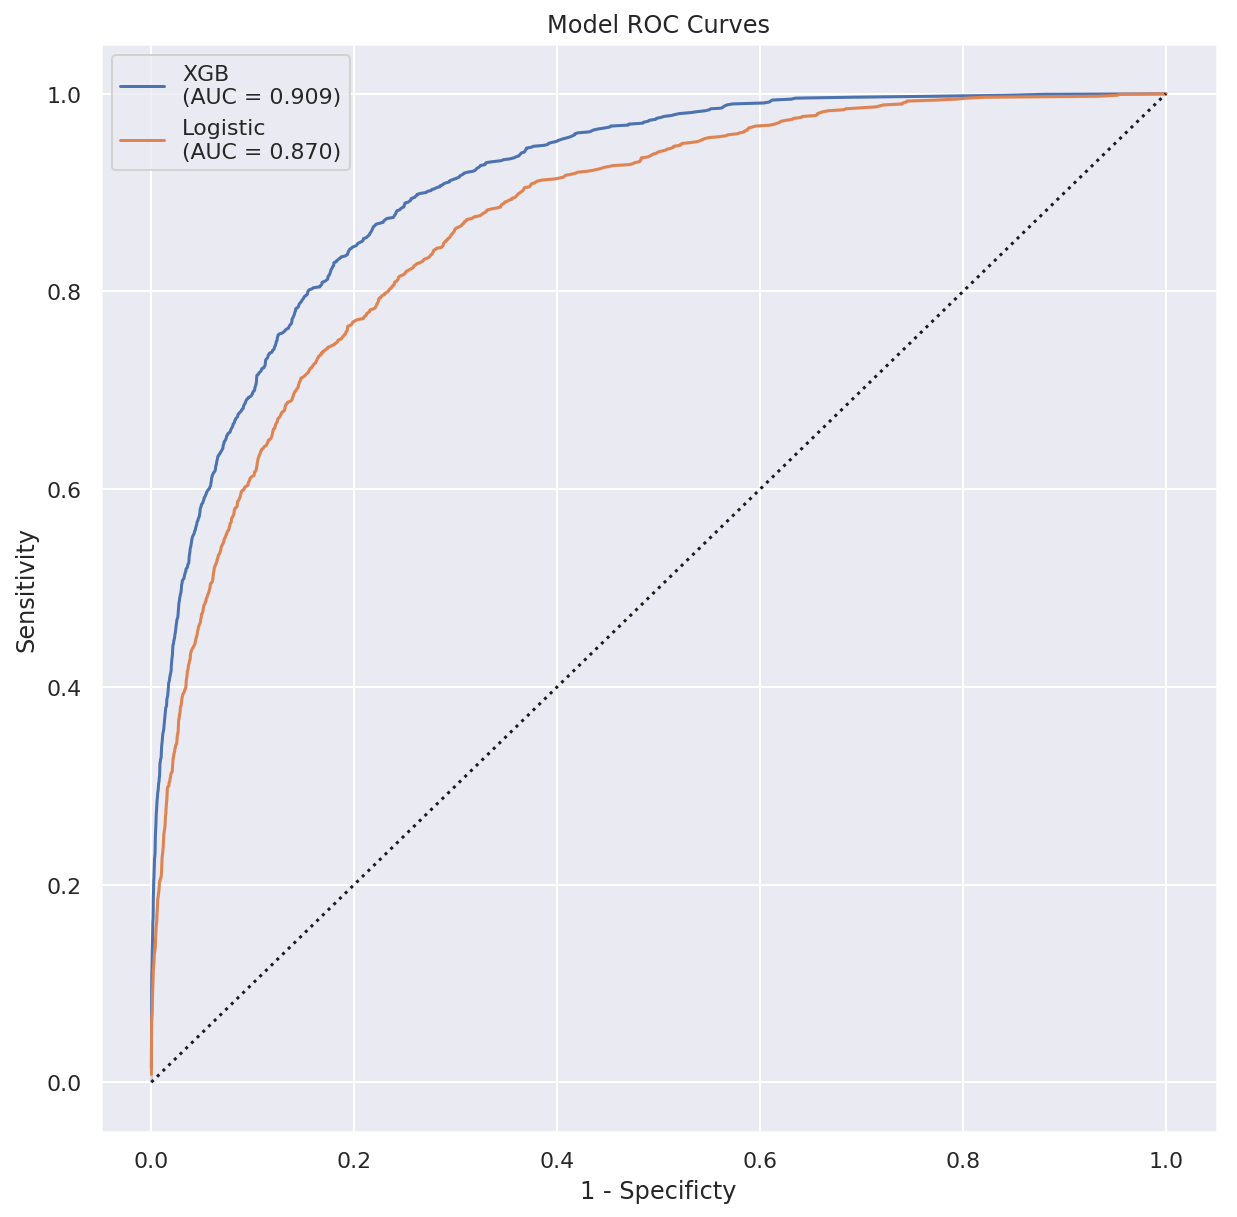

In [27]:
gen_auc_plot(models=[xgb_classifier, logistic_classifier], 
             names=['XGB', 'Logistic'], X=test_X, 
             y=test_y.values, title='Model ROC Curves')

From a discrimination standpoint our model performs fairly well out of the box. The logistic model does similar to the originally published APACHE IV model, and the XGB model bests them both. Next, we examine calibration.

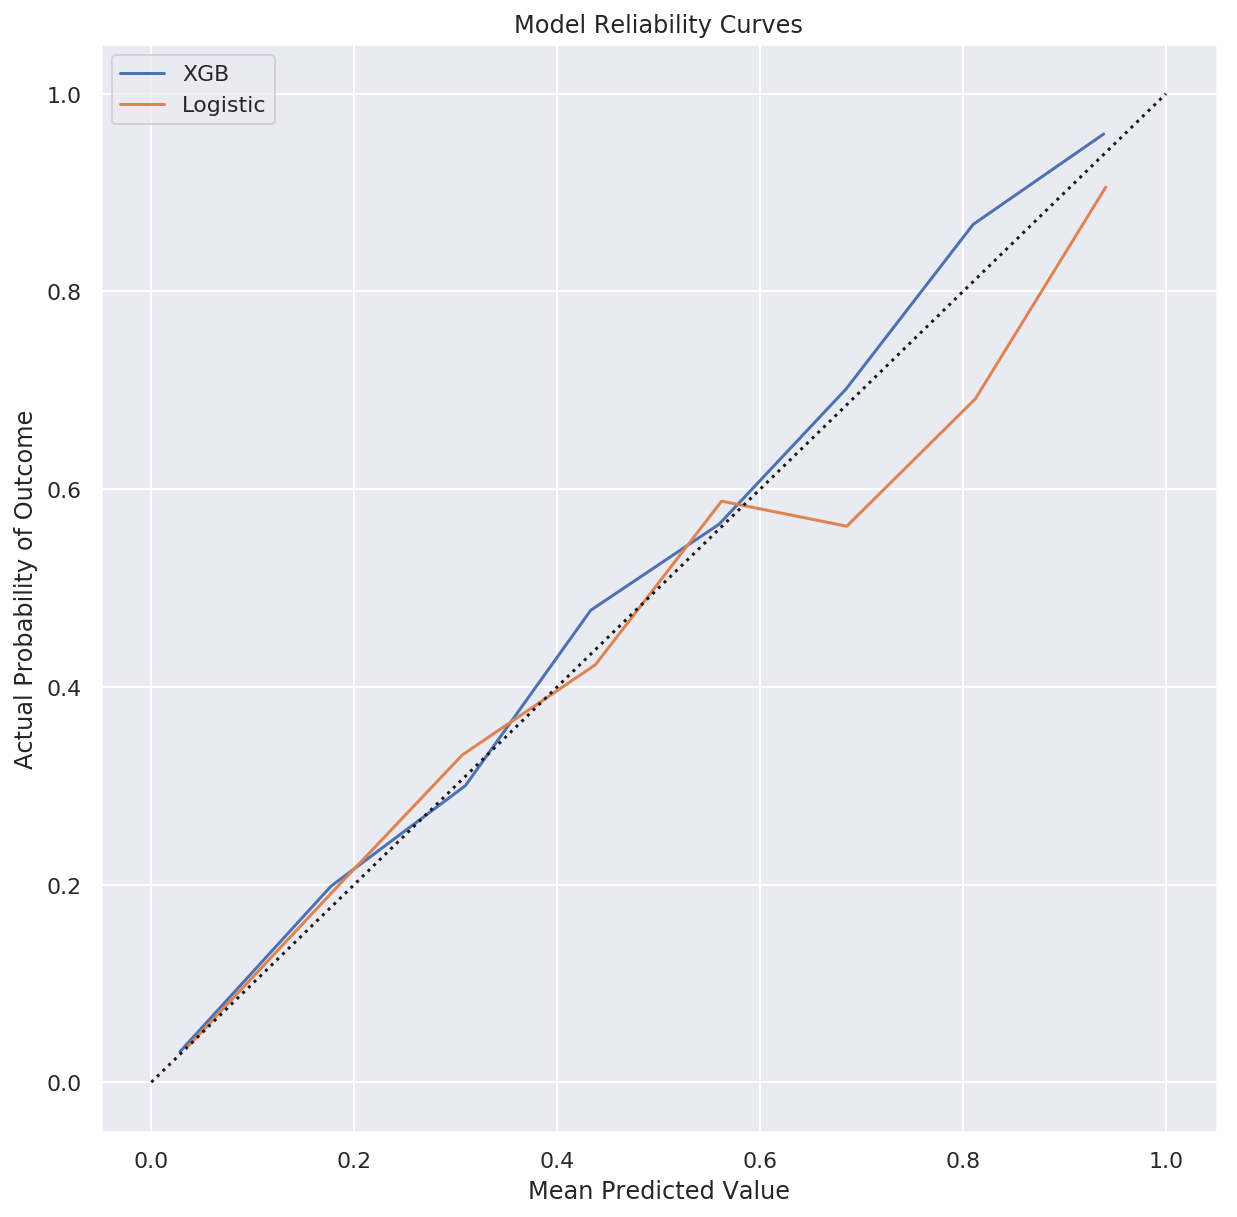

In [28]:
gen_calib_plot(models=[xgb_classifier, logistic_classifier], 
             names=['XGB', 'Logistic'], X=test_X, 
             y=test_y.values, title='Model Reliability Curves')

The logistic model appears better calibrated here with the XGB model over predicting mortality toward the higher end of the risk spectrum. In general, logistic models are the best calibrated models out of the box, but there are many existing methods for improving XGB calibration. Finally, precision and recall.

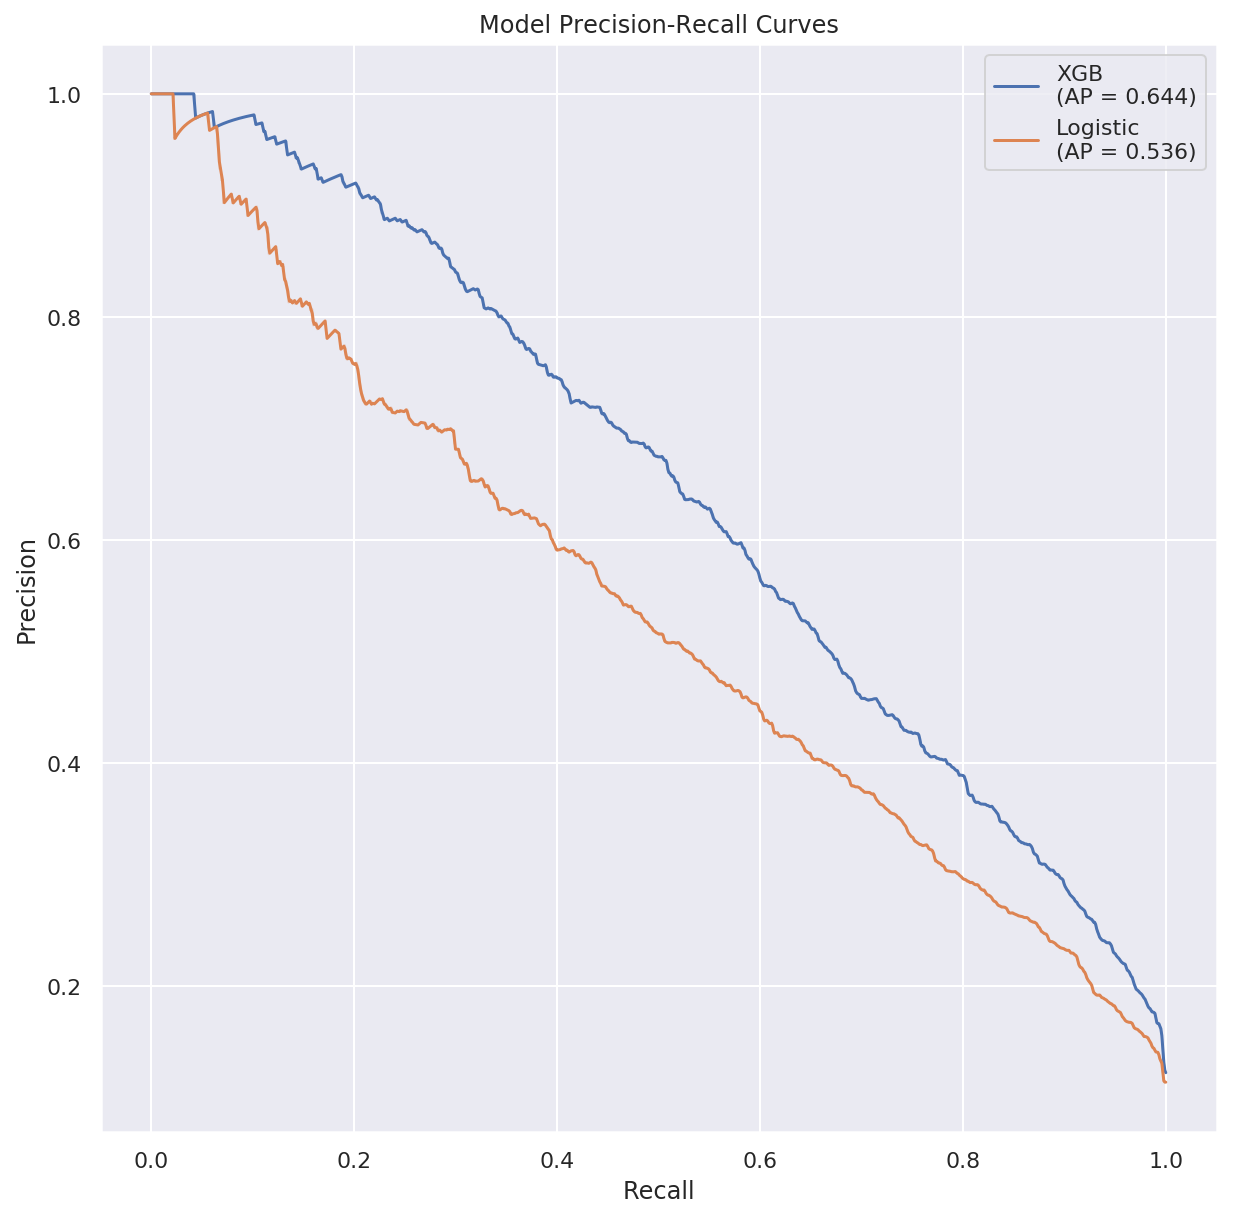

In [29]:
gen_prc_plot(models=[xgb_classifier, logistic_classifier], 
             names=['XGB', 'Logistic'], X=test_X, 
             y=test_y.values, title='Model Precision-Recall Curves')

Here the XGB model is quite superior.

As a lost point to this demonstration, we will look at how we develop an understanding of the way our model is making predictions. To do this we will generate an importance matrix based on the average information gain for each feature, and then we will plot the 10 most important features.

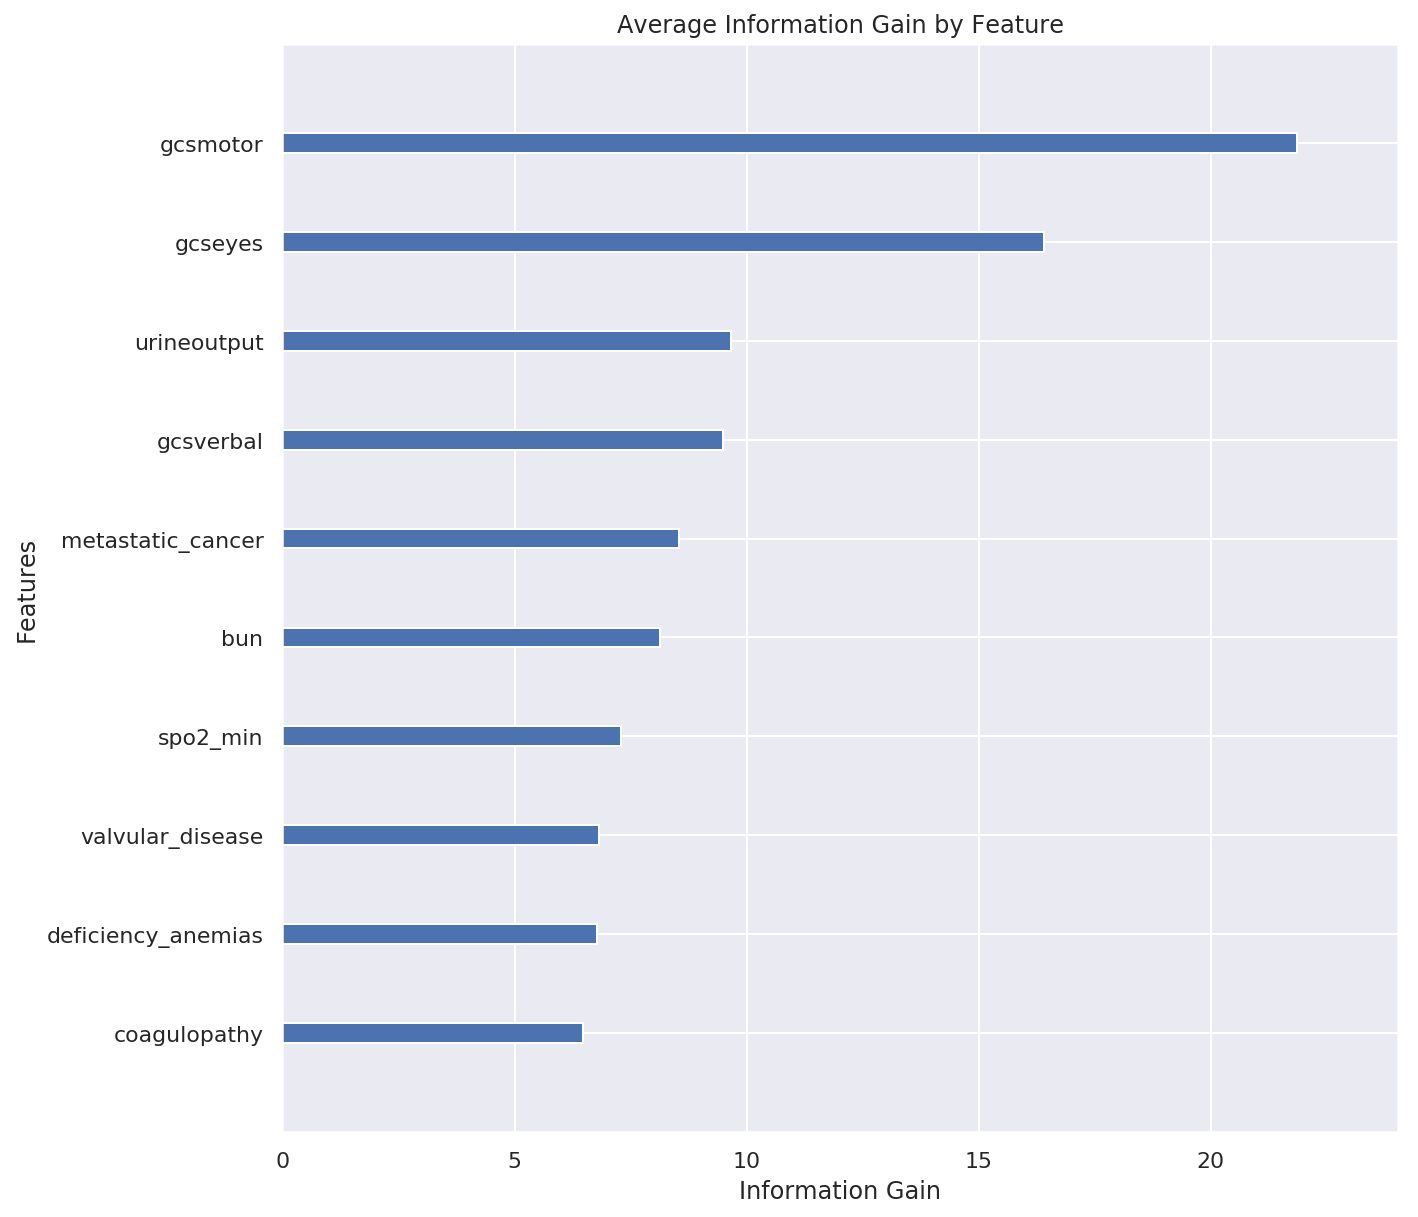

In [30]:
imp_matrix = xgb_classifier.get_booster().get_score(importance_type='gain')
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=10, importance_type='gain', 
                xlabel='Information Gain', ax=plt.axes(), show_values=False,
               title='Average Information Gain by Feature')
plt.show()

Although not as directly interpretable as regression coefficients, we see that the features used agree strongly with our intuition. For example, the reliance on GCS tells use that the model derives a lot from a pateint initial mental status on presentation to the ICU, and the use of urine output, tells a bit about renal failure and volume status. While we could continue to explore this model further, this is a good place to stop and the above should provide the basic knowledge necessary to start playing with gradient boosting classification trees.